###### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/cmamega_example.ipynb)

# Optimizing with CMA-ME in Jax

This notebook shows how to use QDax to find diverse and performing parameters on the Rastrigin problem with [CMA-ME](https://arxiv.org/pdf/1912.02400.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ME emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import math

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex
    
try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_emitter import CMAEmitter
from qdax.core.emitters.cma_opt_emitter import CMAOptimizingEmitter
from qdax.core.emitters.cma_rnd_emitter import CMARndEmitter
from qdax.core.emitters.cma_multi_emitter import CMAPoolEmitter
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire
# from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.plotting import plot_multidimensional_map_elites_grid

from typing import Dict

Mean:  [3.0754995 0.2740465]
Cov:  [[ 0.7702234  -0.43205717]
 [-0.43205717  1.352357  ]]
Mean:  [0.9164108 3.7905252]
Cov:  [[5.2062883e-06 4.5060633e-06]
 [4.5060633e-06 4.0485638e-06]]
Mean:  [3.5398507 3.8561532]
Cov:  [[ 0.03443907 -0.01027214]
 [-0.01027214  0.03651101]]


In [26]:
# from jax.config import config

# config.update('jax_disable_jit', True)

## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [27]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 300 #70000 #10000
num_dimensions = 2 #1000 #@param {type:"integer"} # try 20 and 100
# num_centroids = 10000 #@param {type:"integer"}
grid_shape = (100, 100) # (500, 500) 
batch_size = 500 #36 #@param {type:"integer"}
sigma_g = 1. #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
min_bd = -5.12 * 0.5 * num_dimensions #@param {type:"number"}
max_bd = 5.12 * 0.5 * num_dimensions #@param {type:"number"}
num_emitters = 3
#@markdown ---

## Defines the scoring function: rastrigin or sphere

In [28]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

# fitness_scoring = sphere_scoring
fitness_scoring = rastrigin_scoring

def clip(x: jnp.ndarray):
    in_bound = (x <= maxval) * (x >= minval)
    return jnp.where(
        condition=in_bound,
        x=x,
        y=(maxval / x)
    )

def _behavior_descriptor_1(x: jnp.ndarray):
    return jnp.sum(clip(x[:x.shape[-1]//2]))

def _behavior_descriptor_2(x: jnp.ndarray):
    return jnp.sum(clip(x[x.shape[-1]//2:]))

def _behavior_descriptors(x: jnp.ndarray):
    return jnp.array([_behavior_descriptor_1(x), _behavior_descriptor_2(x)])

In [29]:
def scoring_function(x):
    scores, descriptors = fitness_scoring(x), _behavior_descriptors(x)
    return scores, descriptors, {}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [30]:
worst_objective = fitness_scoring(-jnp.ones(num_dimensions) * 5.12)
# worst_objective = rastrigin_scoring(jnp.zeros(num_dimensions))
best_objective = fitness_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

num_centroids = math.prod(grid_shape)

def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) * 100 / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) # / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define the initial population, the emitter and the MAP Elites instance

The emitter is defined using the CMAME emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-ME algorithm.

In [31]:
random_key = jax.random.PRNGKey(0)
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions))

centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_bd,
    maxval=max_bd,
)

# Define emitter
import functools
from qdax.core.emitters.mutation_operators import isoline_variation
variation_fn = functools.partial(
    isoline_variation, iso_sigma=0.5, line_sigma=0.
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

# emitter = CMAOptimizingEmitter(
emitter = CMAEmitter(
# emitter = CMARndEmitter(
    batch_size=batch_size,
    genotype_dim=num_dimensions,
    centroids=centroids,
    sigma_g=sigma_g,
    min_count=1,
    max_count=20, #20, # None
)

emitter = CMAPoolEmitter(
    num_states=num_emitters,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
#     emitter=mixing_emitter,
    metrics_function=metrics_fn
)

In [32]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

In [33]:
%%time

means = [emitter_state.emitter_states.cmaes_state.mean]
covs = [emitter_state.emitter_states.cmaes_state.cov_matrix]
repertoires = [repertoire]

for i in range(num_iterations):
    
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=1,
    )
    
    print("Emitter state current index: ", emitter_state.current_index)
    print("Emitter state counts: ", emitter_state.emitter_states.emit_count)
    
    
    means.append(emitter_state.emitter_states.cmaes_state.mean)
    covs.append(emitter_state.emitter_states.cmaes_state.cov_matrix)
    repertoires.append(repertoire)

Emitter state current index:  2
Emitter state counts:  [1 1 0]
Emitter state current index:  0
Emitter state counts:  [1 1 1]
Emitter state current index:  1
Emitter state counts:  [2 1 1]
Emitter state current index:  2
Emitter state counts:  [2 2 1]
Emitter state current index:  0
Emitter state counts:  [2 2 2]
Emitter state current index:  1
Emitter state counts:  [3 2 2]
Emitter state current index:  2
Emitter state counts:  [3 3 2]
Emitter state current index:  0
Emitter state counts:  [3 3 3]
Emitter state current index:  1
Emitter state counts:  [4 3 3]
Emitter state current index:  2
Emitter state counts:  [4 4 3]
Emitter state current index:  0
Emitter state counts:  [4 4 4]
Emitter state current index:  1
Emitter state counts:  [5 4 4]
Emitter state current index:  2
Emitter state counts:  [5 5 4]
Emitter state current index:  0
Emitter state counts:  [5 5 5]
Emitter state current index:  1
Emitter state counts:  [6 5 5]
Emitter state current index:  2
Emitter state counts:  

Emitter state current index:  2
Emitter state counts:  [2 4 3]
Emitter state current index:  0
Emitter state counts:  [2 4 4]
Emitter state current index:  1
Emitter state counts:  [3 4 4]
Emitter state current index:  2
Emitter state counts:  [3 5 4]
Emitter state current index:  0
Emitter state counts:  [3 5 5]
Emitter state current index:  1
Emitter state counts:  [4 5 5]
Emitter state current index:  2
Emitter state counts:  [4 6 5]
Emitter state current index:  0
Emitter state counts:  [4 6 6]
Emitter state current index:  1
Emitter state counts:  [5 6 6]
Emitter state current index:  2
Emitter state counts:  [5 7 6]
Emitter state current index:  0
Emitter state counts:  [5 7 7]
Emitter state current index:  1
Emitter state counts:  [6 7 7]
Emitter state current index:  2
Emitter state counts:  [6 8 7]
Emitter state current index:  0
Emitter state counts:  [6 8 0]
Emitter state current index:  1
Emitter state counts:  [7 8 0]
Emitter state current index:  2
Emitter state counts:  

Emitter state current index:  1
Emitter state counts:  [ 4 12  1]
Emitter state current index:  2
Emitter state counts:  [ 4 13  1]
Emitter state current index:  0
Emitter state counts:  [ 4 13  2]
Emitter state current index:  1
Emitter state counts:  [ 5 13  2]
Emitter state current index:  2
Emitter state counts:  [5 0 2]
Emitter state current index:  0
Emitter state counts:  [5 0 3]
Emitter state current index:  1
Emitter state counts:  [6 0 3]
Emitter state current index:  2
Emitter state counts:  [6 1 3]
Emitter state current index:  0
Emitter state counts:  [6 1 4]
Emitter state current index:  1
Emitter state counts:  [7 1 4]
Emitter state current index:  2
Emitter state counts:  [7 2 4]
Emitter state current index:  0
Emitter state counts:  [7 2 5]
Emitter state current index:  1
Emitter state counts:  [8 2 5]
Emitter state current index:  2
Emitter state counts:  [8 3 5]
Emitter state current index:  0
Emitter state counts:  [8 3 6]
Emitter state current index:  1
Emitter sta

In [34]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 150000: 87.29000091552734
max_fitness after 150000: 99.92058563232422
qd_score after 150000: 544045.625


In [35]:
metrics

{'coverage': DeviceArray([87.29], dtype=float32),
 'max_fitness': DeviceArray([99.920586], dtype=float32),
 'qd_score': DeviceArray([544045.6], dtype=float32)}

In [36]:
# #@title Visualization

# # create the x-axis array
# env_steps = jnp.arange(num_iterations) * batch_size

# # create the plots and the grid
# fig, axes = plot_map_elites_results(
#     env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
# )

In [37]:
emitter_state.current_index

DeviceArray(1, dtype=int32, weak_type=True)

In [38]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plot_map_elites_results(
    env_steps: jnp.ndarray,
    metrics: Dict,
    repertoire: MapElitesRepertoire,
    min_bd: jnp.ndarray,
    max_bd: jnp.ndarray,
):
    """Plots three usual QD metrics, namely the coverage, the maximum fitness
    and the QD-score, along the number of environment steps. This function also
    plots a visualisation of the final map elites grid obtained. It ensures that
    those plots are aligned together to give a simple and efficient visualisation
    of an optimization process.

    Args:
        env_steps: the array containing the number of steps done in the environment.
        metrics: a dictionary containing metrics from the optimizatoin process.
        repertoire: the final repertoire obtained.
        min_bd: the mimimal possible values for the bd.
        max_bd: the maximal possible values for the bd.

    Returns:
        A figure and axes with the plots of the metrics and visualisation of the grid.
    """
    # Customize matplotlib params
    font_size = 16
    params = {
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "text.usetex": False,
        "axes.titlepad": 10,
    }

    mpl.rcParams.update(params)

    # Visualize the training evolution and final repertoire
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

    # env_steps = jnp.arange(num_iterations) * episode_length * batch_size

    axes[0].plot(env_steps, metrics["coverage"])
    axes[0].set_xlabel("Environment steps")
    axes[0].set_ylabel("Coverage in %")
    axes[0].set_title("Coverage evolution during training")
    axes[0].set_aspect(0.95 / axes[0].get_data_ratio(), adjustable="box")

    axes[1].plot(env_steps, metrics["max_fitness"])
    axes[1].set_xlabel("Environment steps")
    axes[1].set_ylabel("Maximum fitness")
    axes[1].set_title("Maximum fitness evolution during training")
    axes[1].set_aspect(0.95 / axes[1].get_data_ratio(), adjustable="box")

    axes[2].plot(env_steps, metrics["qd_score"])
    axes[2].set_xlabel("Environment steps")
    axes[2].set_ylabel("QD Score")
    axes[2].set_title("QD Score evolution during training")
    axes[2].set_aspect(0.95 / axes[2].get_data_ratio(), adjustable="box")

#     _, axes = plot_2d_map_elites_repertoire(
#         centroids=repertoire.centroids,
#         repertoire_fitnesses=repertoire.fitnesses,
#         minval=min_bd,
#         maxval=max_bd,
#         repertoire_descriptors=repertoire.descriptors,
#         ax=axes[3],
#     )

    return fig, axes

In [39]:
# env_steps = jnp.arange(num_iterations) * batch_size

# fig, axes = plot_map_elites_results(
#     env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
# )

In [40]:
# fig, axes = plot_multidimensional_map_elites_grid(
#     repertoire=repertoire,
#     minval=jnp.array([min_bd, min_bd]),
#     maxval=jnp.array([max_bd, max_bd]),
#     grid_shape=grid_shape,
# )

In [41]:
means, covs

([DeviceArray([[0.46736008, 0.47315505],
               [0.        , 0.        ],
               [0.        , 0.        ]], dtype=float32),
  DeviceArray([[0.46736008, 0.47315505],
               [0.33956188, 0.2780319 ],
               [0.        , 0.        ]], dtype=float32),
  DeviceArray([[0.46736008, 0.47315505],
               [0.33956188, 0.2780319 ],
               [0.27993062, 0.30333626]], dtype=float32),
  DeviceArray([[0.54751647, 0.5963102 ],
               [0.33956188, 0.2780319 ],
               [0.27993062, 0.30333626]], dtype=float32),
  DeviceArray([[0.54751647, 0.5963102 ],
               [0.66496825, 0.5169401 ],
               [0.27993062, 0.30333626]], dtype=float32),
  DeviceArray([[0.54751647, 0.5963102 ],
               [0.66496825, 0.5169401 ],
               [0.49577108, 0.5200622 ]], dtype=float32),
  DeviceArray([[0.80958843, 0.8225589 ],
               [0.66496825, 0.5169401 ],
               [0.49577108, 0.5200622 ]], dtype=float32),
  DeviceArray([[0.80

## Trying dynamic visualisation tool

In [42]:
from matplotlib.patches import Ellipse

# Import animation package
from matplotlib.animation import FuncAnimation

In [43]:
# Change matplotlib backend
%matplotlib notebook

In [44]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


<IPython.core.display.Javascript object>


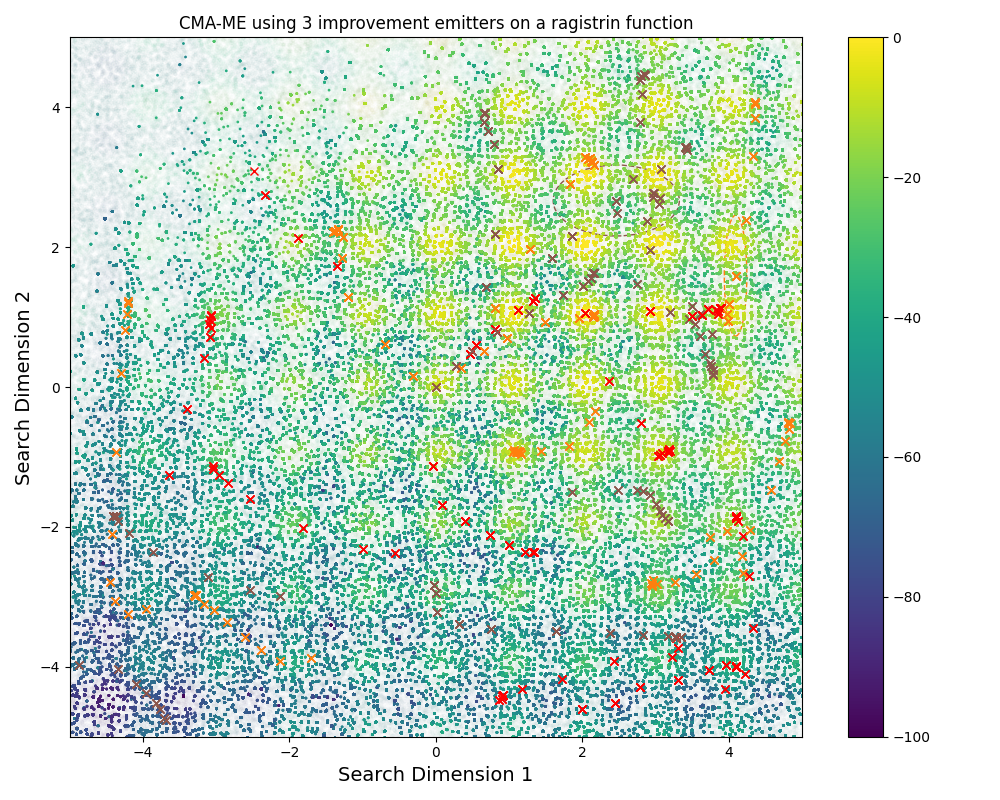

In [45]:
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# # sample points to show fitness landscape
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key, minval=-5, maxval=5, shape=(200000, 2))

f_x = jax.vmap(fitness_scoring)(x)


# plot fitness landscape
plot1 = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=5, alpha=0.01)
# fig.colorbar(plot1)

fake_plot = ax.scatter(
    jnp.array([maxval * 100, 100 * minval]), jnp.array([maxval * 100, minval * 100]), c=[-100, 0], s=0.01
)
fig.colorbar(fake_plot)


colors = ['r', 'tab:orange', 'tab:brown']
ellipses = []
for j in range(num_emitters):
    mean = means[0][j]
    cov = covs[0][j]
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color=colors[j], ls='--')
    
    ellipses.append(ellipse)
    ax.add_patch(ellipse)
    

def single_frame_plot(i, j):
    # get data
    mean = means[i][j]
    cov = covs[i][j]
    
    print("Mean: ", mean)
    print("Cov: ", cov)
    
    ellipses[j].set_center((mean[0], mean[1]))
    ellipses[j].width = cov[0, 0]
    ellipses[j].height = cov[1, 1]

    ax.plot(mean[0], mean[1], color=colors[j], marker='x')
    
def frame_plot(i):
    for j in range(num_emitters):
        single_frame_plot(i, j)
    pass

    latest_genotypes = repertoires[i].genotypes
    latest_fitnesses = repertoires[i].fitnesses
    
    ax.scatter(latest_genotypes[:, 0], latest_genotypes[:, 1], c=latest_fitnesses, s=1.)


# plot cma-es trajectory
traj_min = 0
traj_max = 500

my_frames = range(traj_min, traj_max)

dynamic_plot = FuncAnimation(fig=fig, func=frame_plot, frames=my_frames, interval=1000, repeat=True)
    
ax.set_title(f"CMA-ME using 3 improvement emitters on a ragistrin function")
plt.xlim([-5, 5])
plt.ylim([-5, 5])

ax.set_xlabel("Search Dimension 1", fontsize=14)
ax.set_ylabel("Search Dimension 2", fontsize=14)

fig.tight_layout()

plt.show()

In [46]:
# Save and show animation
dynamic_plot.save('cma_me_ragistrin.gif', writer='imagemagick', fps=10)

Mean:  [0.46736008 0.47315505]
Cov:  [[0.3375236  0.22579935]
 [0.22579935 0.35126674]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.46736008 0.47315505]
Cov:  [[0.3375236  0.22579935]
 [0.22579935 0.35126674]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.46736008 0.47315505]
Cov:  [[0.3375236  0.22579935]
 [0.22579935 0.35126674]]
Mean:  [0.33956188 0.2780319 ]
Cov:  [[0.910552   0.18540043]
 [0.18540043 0.9482188 ]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.46736008 0.47315505]
Cov:  [[0.3375236  0.22579935]
 [0.22579935 0.35126674]]
Mean:  [0.33956188 0.2780319 ]
Cov:  [[0.910552   0.18540043]
 [0.18540043 0.9482188 ]]
Mean:  [0.27993062 0.30333626]
Cov:  [[0.9077449  0.07392199]
 [0.07392199 0.81737196]]
Mean:  [0.54751647 0.5963102 ]
Cov:  [[0.23579012 0.16636057]
 [0.16636057 0.25328457]]
Mean:  [0.33956188 0.2780319 ]
Cov:  [[0.910552   0.18540043]
 [0.18540043 0.9482188 ]]
Mean:  [

Mean:  [ 0.73901176 -2.119211  ]
Cov:  [[ 0.4819414  -0.04468289]
 [-0.04468289  0.1685215 ]]
Mean:  [-0.31113023  0.16185248]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [2.156021 1.637348]
Cov:  [[1.1081805e-06 2.3253735e-06]
 [2.3253733e-06 5.1156503e-06]]
Mean:  [ 0.73901176 -2.119211  ]
Cov:  [[ 0.4819414  -0.04468289]
 [-0.04468289  0.1685215 ]]
Mean:  [-0.31113023  0.16185248]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-0.01971146 -2.8246155 ]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 0.999637  -2.2644014]
Cov:  [[ 0.19269173 -0.0252698 ]
 [-0.0252698   0.06083202]]
Mean:  [-0.31113023  0.16185248]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-0.01971146 -2.8246155 ]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 0.999637  -2.2644014]
Cov:  [[ 0.19269173 -0.0252698 ]
 [-0.0252698   0.06083202]]
Mean:  [-0.69850725  0.6182159 ]
Cov:  [[ 1.5676157  -0.22691435]
 [-0.22691435  2.0167882 ]]
Mean:  [-0.01971146 -2.8246155 ]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 0.999637  -2.2644014]
Cov:  [[ 0.19269173 -0.0252698 ]
 [-0.0252698   0.06083202]

Mean:  [ 3.314117  -4.1864367]
Cov:  [[0.49890113 0.15326796]
 [0.15326796 0.24086979]]
Mean:  [0.8134701 1.1305145]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 3.2728348 -3.577201 ]
Cov:  [[ 1.6014965e-03 -3.4180703e-05]
 [-3.4180706e-05  4.1965982e-06]]
Mean:  [ 3.728732  -4.0458794]
Cov:  [[0.19445175 0.07166264]
 [0.07166264 0.09256539]]
Mean:  [0.8134701 1.1305145]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 3.2728348 -3.577201 ]
Cov:  [[ 1.6014965e-03 -3.4180703e-05]
 [-3.4180706e-05  4.1965982e-06]]
Mean:  [ 3.728732  -4.0458794]
Cov:  [[0.19445175 0.07166264]
 [0.07166264 0.09256539]]
Mean:  [1.2910826 1.9785311]
Cov:  [[1.6327499  0.18410134]
 [0.18410134 1.8459827 ]]
Mean:  [ 3.2728348 -3.577201 ]
Cov:  [[ 1.6014965e-03 -3.4180703e-05]
 [-3.4180706e-05  4.1965982e-06]]
Mean:  [ 3.728732  -4.0458794]
Cov:  [[0.19445175 0.07166264]
 [0.07166264 0.09256539]]
Mean:  [1.2910826 1.9785311]
Cov:  [[1.6327499  0.18410134]
 [0.18410134 1.8459827 ]]
Mean:  [ 3.2777631 -3.580859 ]
Cov:  [[ 1.0716870e-05 -1

Mean:  [3.5041108 1.0156158]
Cov:  [[0.38987467 0.02796124]
 [0.02796124 0.51440054]]
Mean:  [3.9933956  0.93743515]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.6667562 3.9240599]
Cov:  [[2.5992931e-04 8.5318476e-07]
 [8.5318476e-07 2.4405804e-04]]
Mean:  [3.5041108 1.0156158]
Cov:  [[0.38987467 0.02796124]
 [0.02796124 0.51440054]]
Mean:  [3.982837  1.0399206]
Cov:  [[0.40180477 0.0478304 ]
 [0.0478304  0.8805499 ]]
Mean:  [0.6667562 3.9240599]
Cov:  [[2.5992931e-04 8.5318476e-07]
 [8.5318476e-07 2.4405804e-04]]
Mean:  [3.5041108 1.0156158]
Cov:  [[0.38987467 0.02796124]
 [0.02796124 0.51440054]]
Mean:  [3.982837  1.0399206]
Cov:  [[0.40180477 0.0478304 ]
 [0.0478304  0.8805499 ]]
Mean:  [1.582828  1.8391217]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [3.6406112 1.0330167]
Cov:  [[ 0.07255551 -0.00212121]
 [-0.00212121  0.14872465]]
Mean:  [3.982837  1.0399206]
Cov:  [[0.40180477 0.0478304 ]
 [0.0478304  0.8805499 ]]
Mean:  [1.582828  1.8391217]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [3.6406112 1.0330167]
Cov: 

Mean:  [-0.99947083 -2.3142173 ]
Cov:  [[ 1.680135  -0.2616872]
 [-0.2616872  1.1222816]]
Mean:  [-2.3920043 -3.752933 ]
Cov:  [[ 0.5889399  -0.19881812]
 [-0.19881812  0.45590997]]
Mean:  [2.788478  3.7876146]
Cov:  [[ 0.35757545 -0.01898327]
 [-0.01898328  1.2858603 ]]
Mean:  [-0.99947083 -2.3142173 ]
Cov:  [[ 1.680135  -0.2616872]
 [-0.2616872  1.1222816]]
Mean:  [-2.6001017 -3.5764084]
Cov:  [[ 0.3439747  -0.13682549]
 [-0.13682549  0.33260444]]
Mean:  [2.788478  3.7876146]
Cov:  [[ 0.35757545 -0.01898327]
 [-0.01898328  1.2858603 ]]
Mean:  [-0.99947083 -2.3142173 ]
Cov:  [[ 1.680135  -0.2616872]
 [-0.2616872  1.1222816]]
Mean:  [-2.6001017 -3.5764084]
Cov:  [[ 0.3439747  -0.13682549]
 [-0.13682549  0.33260444]]
Mean:  [2.810955 4.195287]
Cov:  [[ 0.1293085  -0.00031932]
 [-0.00031932  0.25863954]]
Mean:  [-1.8080151 -2.0171518]
Cov:  [[ 1.3581269  -0.36848238]
 [-0.3684824   0.82455665]]
Mean:  [-2.6001017 -3.5764084]
Cov:  [[ 0.3439747  -0.13682549]
 [-0.13682549  0.33260444]]
Me

Mean:  [ 4.2757077 -2.7043204]
Cov:  [[ 0.09444337 -0.06082086]
 [-0.06082086  0.7312112 ]]
Mean:  [-3.9526086 -3.1703637]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-4.192706 -2.090106]
Cov:  [[ 0.08916812 -0.04018788]
 [-0.04018788  0.08860365]]
Mean:  [ 4.2757077 -2.7043204]
Cov:  [[ 0.09444337 -0.06082086]
 [-0.06082086  0.7312112 ]]
Mean:  [-3.9526086 -3.1703637]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-4.333536 -1.911025]
Cov:  [[ 0.02074917 -0.00969439]
 [-0.00969439  0.02056137]]
Mean:  [ 4.18932   -2.1325965]
Cov:  [[ 0.03301304 -0.03816592]
 [-0.03816592  0.24130346]]
Mean:  [-3.9526086 -3.1703637]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-4.333536 -1.911025]
Cov:  [[ 0.02074917 -0.00969439]
 [-0.00969439  0.02056137]]
Mean:  [ 4.18932   -2.1325965]
Cov:  [[ 0.03301304 -0.03816592]
 [-0.03816592  0.24130346]]
Mean:  [-4.2072954 -3.2456894]
Cov:  [[0.56094617 0.00609249]
 [0.0060925  1.4334612 ]]
Mean:  [-4.333536 -1.911025]
Cov:  [[ 0.02074917 -0.00969439]
 [-0.00969439  0.02056137]]
Mean:  [ 4.18932

Mean:  [ 2.8054156  -0.51840746]
Cov:  [[ 0.8989543  -0.21927348]
 [-0.21927346  0.9780314 ]]
Mean:  [-4.1994963  1.2312179]
Cov:  [[3.7635303e-07 4.4150493e-06]
 [4.4150497e-06 7.4043222e-05]]
Mean:  [ 2.8256822 -1.4850345]
Cov:  [[ 0.08037332 -0.00919968]
 [-0.00919968  0.07838763]]
Mean:  [ 3.0287366 -0.9894432]
Cov:  [[ 0.29956403 -0.0812462 ]
 [-0.0812462   0.34458217]]
Mean:  [-4.1994963  1.2312179]
Cov:  [[3.7635303e-07 4.4150493e-06]
 [4.4150497e-06 7.4043222e-05]]
Mean:  [ 2.8256822 -1.4850345]
Cov:  [[ 0.08037332 -0.00919968]
 [-0.00919968  0.07838763]]
Mean:  [ 3.0287366 -0.9894432]
Cov:  [[ 0.29956403 -0.0812462 ]
 [-0.0812462   0.34458217]]
Mean:  [ 4.199374  -2.6524491]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 2.8256822 -1.4850345]
Cov:  [[ 0.08037332 -0.00919968]
 [-0.00919968  0.07838763]]
Mean:  [ 3.0287366 -0.9894432]
Cov:  [[ 0.29956403 -0.0812462 ]
 [-0.0812462   0.34458217]]
Mean:  [ 4.199374  -2.6524491]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 2.927003  -1.5488807]
Cov:  [[ 0.

Mean:  [ 3.1744351  -0.92079955]
Cov:  [[ 1.2665818e-07 -3.1520482e-08]
 [-3.1520482e-08  3.4136004e-08]]
Mean:  [ 4.811721   -0.50824136]
Cov:  [[ 1.6710656e-07 -1.5502538e-07]
 [-1.5502539e-07  5.9229620e-07]]
Mean:  [3.49503   1.1589266]
Cov:  [[1.002387   0.27260652]
 [0.2726065  1.0931368 ]]
Mean:  [-3.6367068 -1.2515032]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 4.811721   -0.50824136]
Cov:  [[ 1.6710656e-07 -1.5502538e-07]
 [-1.5502539e-07  5.9229620e-07]]
Mean:  [3.49503   1.1589266]
Cov:  [[1.002387   0.27260652]
 [0.2726065  1.0931368 ]]
Mean:  [-3.6367068 -1.2515032]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 3.9804277 -2.0572078]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [3.49503   1.1589266]
Cov:  [[1.002387   0.27260652]
 [0.2726065  1.0931368 ]]
Mean:  [-3.6367068 -1.2515032]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 3.9804277 -2.0572078]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [3.4573417  0.97702926]
Cov:  [[0.70736146 0.33732906]
 [0.33732906 0.817714  ]]
Mean:  [-3.3970428  -0.31091225]
Cov:  [[0.7242777  0.26

Mean:  [ 3.306449  -3.7282481]
Cov:  [[ 1.2956791  -0.04284181]
 [-0.04284183  1.1161764 ]]
Mean:  [ 2.968393  -2.7639828]
Cov:  [[ 1.0054626e-05 -9.6962754e-07]
 [-9.6962742e-07  1.7278389e-06]]
Mean:  [3.7837873  0.18289058]
Cov:  [[1.3759577e-05 2.6280304e-06]
 [2.6280304e-06 8.0914964e-04]]
Mean:  [ 3.306449  -3.7282481]
Cov:  [[ 1.2956791  -0.04284181]
 [-0.04284183  1.1161764 ]]
Mean:  [ 2.968393  -2.7639828]
Cov:  [[ 1.0054626e-05 -9.6962754e-07]
 [-9.6962742e-07  1.7278389e-06]]
Mean:  [3.786057   0.17807299]
Cov:  [[ 2.5862971e-06 -4.8499332e-06]
 [-4.8499328e-06  1.7340713e-04]]
Mean:  [ 3.2312903 -3.8638296]
Cov:  [[ 2.0109468  -0.29367918]
 [-0.29367918  0.84869593]]
Mean:  [ 2.968393  -2.7639828]
Cov:  [[ 1.0054626e-05 -9.6962754e-07]
 [-9.6962742e-07  1.7278389e-06]]
Mean:  [3.786057   0.17807299]
Cov:  [[ 2.5862971e-06 -4.8499332e-06]
 [-4.8499328e-06  1.7340713e-04]]
Mean:  [ 3.2312903 -3.8638296]
Cov:  [[ 2.0109468  -0.29367918]
 [-0.29367918  0.84869593]]
Mean:  [ 2.9

Mean:  [ 0.9215324 -4.403593 ]
Cov:  [[6.0174448e-06 5.6345016e-06]
 [5.6345016e-06 5.3892709e-06]]
Mean:  [ 1.103281   -0.91852385]
Cov:  [[0.11560305 0.01186915]
 [0.01186915 0.00790534]]
Mean:  [2.9195423 1.9652473]
Cov:  [[0.9839107  0.15098077]
 [0.15098083 1.6862912 ]]
Mean:  [ 0.9215609 -4.403371 ]
Cov:  [[1.3647938e-06 1.1776783e-06]
 [1.1776783e-06 1.0190798e-06]]
Mean:  [ 1.103281   -0.91852385]
Cov:  [[0.11560305 0.01186915]
 [0.01186915 0.00790534]]
Mean:  [2.9195423 1.9652473]
Cov:  [[0.9839107  0.15098077]
 [0.15098083 1.6862912 ]]
Mean:  [ 0.9215609 -4.403371 ]
Cov:  [[1.3647938e-06 1.1776783e-06]
 [1.1776783e-06 1.0190798e-06]]
Mean:  [ 1.0531484 -0.9243188]
Cov:  [[0.03950305 0.00103684]
 [0.00103684 0.00221695]]
Mean:  [2.9195423 1.9652473]
Cov:  [[0.9839107  0.15098077]
 [0.15098083 1.6862912 ]]
Mean:  [ 0.9215609 -4.403371 ]
Cov:  [[1.3647938e-06 1.1776783e-06]
 [1.1776783e-06 1.0190798e-06]]
Mean:  [ 1.0531484 -0.9243188]
Cov:  [[0.03950305 0.00103684]
 [0.00103684

IndexError: list index out of range

In [55]:
import numpy as np

N = 100
x = np.linspace(-4.0, 4.0, N)
y = np.linspace(-4.0, 4.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
z = Z1 + 50 * Z2

In [56]:
X

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [57]:
z

array([[2.26032941e-06, 3.23967763e-06, 4.60936870e-06, ...,
        4.60936870e-06, 3.23967763e-06, 2.26032941e-06],
       [2.65247783e-06, 3.80173485e-06, 5.40905598e-06, ...,
        5.40905598e-06, 3.80173485e-06, 2.65247783e-06],
       [3.10251457e-06, 4.44676206e-06, 6.32679181e-06, ...,
        6.32679181e-06, 4.44676206e-06, 3.10251457e-06],
       ...,
       [3.10251457e-06, 4.44676206e-06, 6.32679181e-06, ...,
        6.32679181e-06, 4.44676206e-06, 3.10251457e-06],
       [2.65247783e-06, 3.80173485e-06, 5.40905598e-06, ...,
        5.40905598e-06, 3.80173485e-06, 2.65247783e-06],
       [2.26032941e-06, 3.23967763e-06, 4.60936870e-06, ...,
        4.60936870e-06, 3.23967763e-06, 2.26032941e-06]])

<IPython.core.display.Javascript object>


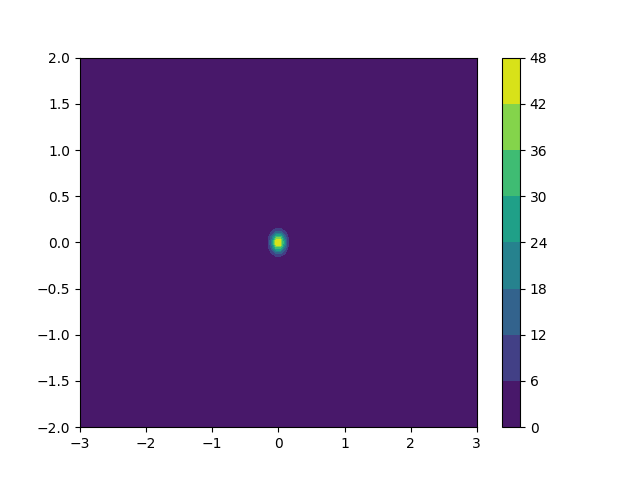

In [59]:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z)

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()